# Adaptative Correlation Aware Regularization 

En esta libreta se encuentra una implementacion de una regresión lineal con este tipo de regularizacion, así mismo se hace comparaciones con las regulaciones mas conocidas como lasso, ridge y elasticnet.



## Penalizaciones

Vamos a definir las funciones de penalizaciones de las regularizaciones, así como su codigo.

### Lasso

Lasso se basa en la distancia l1 para implementar su penalizacion, la formula es la siguiente:  
$$ 
Lasso(W) = \lambda_{c}\sum_{i=1}^{n} | w_i |
$$
Hagamos una función en python para calcular esta penalizacion.

In [650]:
import numpy as np
from numpy.typing import NDArray

def lasso_penalty(lambda_c : np.float64, W : NDArray[np.float64]) -> np.float64:
    return np.sum(np.abs(W))

### Ridge 

Ridge se basa en la distancia l2 para implementar su penalización la formula es la siguiente:
$$ 
R(W) = \lambda_{c} \sum_{i=1}^{n} (w_i)^2
$$

Hagamos una función en python para calcular la penalización.

In [651]:
def ridge_penalty(lambda_c : np.float64, W : NDArray[np.float64]) -> np.float64:
    return lambda_c * np.sum(W**2)

### Elastic Net

Elastic Net intenta usar ambas por medio de una combinación lineal, la cual esta dada por la siguiente formula:
$$
R(W) = \lambda_{r} \sum_{i=1}^{n} (w_i)^2 + \lambda_{l}\sum_{i=1}^{n} | w_i |
$$

Hagamos una función en python para calcular esta penalización.



In [652]:
def elasticnet_penalty(lambda_r : np.float64, lambda_l : np.float64, W : NDArray[np.float64]) -> np.float64:
    return ridge_penalty(lambda_r, W) + lasso_penalty(lambda_l, W)

### Adaptative Correlation Aware

La penalizacion de lasso ayuda a reducir características forzandolas a reducirse hasta 0, pero es inestable cuando las variables estan muy correlacionadas, en cambio ridge tiene mas estabilidad ante esto pero a cambio no reduce características. Queriendo obtener lo mejor de los dos mundos naturalmente sale la idea de usar de alguna forma las correlaciones para hacer un balance entre estas dos como lo hace eslatic net. 

De alguna forma con las correlaciones queremos algo como:
$$
R(W, C) = C\,R_{ridge}(W) + (1 - C)\,R_{lasso}(W) 
$$
Donde $C$ es la matriz de correlaciones de las características.

Ahora como necesitamos de alguna forma una correlación por característica, rescribamos la formula como sigue:
$$
R(W, C) = \lambda_{r} \sum_{i=1}^{n} c_i(w_i)^2 + \lambda_{l}\sum_{i=1}^{n} (1-c_i)| w_i |
$$

Una pregunta que surge de aquí es que es $c_i$, si nos fijamos no es una entrada de la matriz $C$ entonces hay que definirla, la propuesta es la siguiente:
$$
c_i = \max_{i \neq j} | C_{ij} | \forall i \in \{ 1,2,..,n\}
$$
Aquí lo que buscamos es lo siguiente:
- Agarramos la característica i-ésima.
- Calculamos su correlacion con todas las demas características.
- Nos quedamos con la correlación mas alta, no importa si es negativa o positiva, por eso el valor absoluto.

Otra cosa importante es que $i \neq j$ ya que la correlacion de una característica consigo misma es 1.

A continuacion haremos el código en python para calcular esta penalización.



In [653]:
def get_max_corr(corr: NDArray[np.float64], i : int) -> np.float64:
    corr_i = corr[:, i]
    corr_i_without_i = np.delete(corr_i, i)
    return np,max(np.abs(corr_i_without_i))

def aca_penalty(lambda_r : np.float64, 
                lambda_l : np.float64, 
                corr: NDArray[np.float64],
                W : NDArray[np.float64]) -> np.float64:
    
    corr_max = np.array([get_max_corr(corr, i) for i in range(corr.shape[1])])  
    return lambda_r * np.sum(corr_max * W**2) + lambda_l * np.sum((1 - corr_max) * np.abs(W))

## Gradientes

Ahora calcularemos los gradientes. Derivaremos el gradiente para aca, junto con su código.

Tenemos que en general para encontrar los parametros optimos de nuestro modelo es:
$$
w^*, b^* = \argmin_{w,b} (E_{in}(w,b) + \lambda R(w))
$$

Y usamos descenso gradiente para calcular estos parametros, en general las formulas son:
$$
w^{(i+1)} = w^{(i)} - \alpha \left(\nabla_{w^{(i)}}E_{in}(w^{(i)}) + \lambda \nabla_{w^{(i)}}R(w^{(i)})\right)
$$

Para las tres regularizaciones (lasso, ridge y elastic net) ya conocemos estas expresiones, así que solo se pondrá el código. Para aca, si derivaremos su gradiente.

In [654]:
def update_bias(W: NDArray[np.float64],
                b: float,
                X: NDArray[np.float64],
                y: NDArray[np.float64],
                alpha: float) -> float:
    m = X.shape[0]
    y_est = X @ W + b
    grad_b = -(1/m) * np.sum(y - y_est)
    return b - alpha * grad_b

def grad(W : NDArray[np.float64],
         b : np.float64,
         X : NDArray[np.float64],
         y : NDArray[np.float64]) -> NDArray[np.float64]:
    
    m = X.shape[0]
    y_est = X @ W + b
    return -(1/m) * X.T @ (y - y_est)

### Lasso

In [655]:
def soft_threshold(W, thresh):
    return np.sign(W) * np.maximum(np.abs(W) - thresh, 0.0)


def update_weights_with_lasso(W : NDArray[np.float64],
               b : np.float64,
               X : NDArray[np.float64],
               y : NDArray[np.float64],
               lambda_c : np.float64, 
               alpha : np.float64) -> NDArray[np.float64]:
    
    grad_W = grad(W, b, X, y)
    W = W - alpha * grad_W
    return soft_threshold(W, alpha * lambda_c)

### Ridge

In [656]:
def update_weights_with_ridge(W : NDArray[np.float64],
               b : np.float64,
               X : NDArray[np.float64],
               y : NDArray[np.float64],
               lambda_c : np.float64, 
               alpha : np.float64) -> NDArray[np.float64]:
    
    return W - alpha * (grad(W,b,X,y) + lambda_c * W)

### Elastic Net

In [657]:
def update_weights_with_elasticnet(W : NDArray[np.float64],
               b : np.float64,
               X : NDArray[np.float64],
               y : NDArray[np.float64],
               lambda_r : np.float64, 
               lambda_l : np.float64, 
               alpha : np.float64) -> NDArray[np.float64]:

    grad_smooth = grad(W, b, X, y) + lambda_r * W

    W_temp = W - alpha * grad_smooth
    
    return soft_threshold(W_temp, alpha * lambda_l)

### Adaptative Correlation Aware

Recordando la formula general:
$$
w^{(i+1)} = w^{(i)} - \alpha \left(\nabla_{w^{(i)}}E_{in}(w^{(i)}) + \lambda \nabla_{w^{(i)}}R(w^{(i)})\right)
$$

Necesitamos derivar solamente esta expresion:
$$
\lambda \nabla_{w^{(i)}}R(w^{(i)}, C)
$$
donde $C$ es la matriz de correlacion.

Anteriormente habiamos definido a $R(W, C)$ como sigue:
$$
R(W, C) = \lambda_{r} \sum_{i=1}^{n} c_i(w_i)^2 + \lambda_{l}\sum_{i=1}^{n} (1-c_i)| w_i |
$$
$$
c_i = \max_{i \neq j} | C_{ij} | \forall i \in \{ 1,2,..,n\}
$$

Expandamos la expresion del gradiente:
$$
\nabla_{w^{(i)}}\left( \lambda_{r} \sum_{i=1}^{n} c_i(w_i)^2 + \lambda_{l}\sum_{i=1}^{n} (1-c_i)| w_i |\right)
$$

Veamos que pasa para el k-ésimo peso $w_k$
$$
\dfrac{\partial}{\partial w_k}\left( \lambda_{r} \sum_{i=1}^{n} c_i(w_i)^2 + \lambda_{l}\sum_{i=1}^{n} (1-c_i)| w_i |\right) = 
\lambda_rc_kw_k + \lambda_l(1 - c_k)sign(w_k)
$$

Y esto se hace para cada entrada en el vector de pesos $W$. Ya en forma matricial nos queda que 
$$
\nabla_{W} R(W, C) = 
\lambda_r \, (C \odot W) 
+ 
\lambda_l \, ((1 - C) \odot \operatorname{sign}(W))
$$
donde $\odot$ denota el producto elemento a elemento.



In [658]:
def update_weights_with_aca(W : NDArray[np.float64],
               b : np.float64,
               X : NDArray[np.float64],
               y : NDArray[np.float64],
               alpha : np.float64,
               lambda_r : np.float64, 
               lambda_l : np.float64,    
               C : NDArray[np.float64],) -> NDArray[np.float64]:
    
    grad_W = grad(W, b, X, y)
    W = W - alpha * (grad_W + lambda_r * C * W)
    # Soft threshold adaptativo
    thresh = alpha * lambda_l * (1 - C)
    return np.sign(W) * np.maximum(np.abs(W) - thresh, 0.0)

## Validación Empírica

### Conjunto de datos con 3 grupos de características:

Cada grupo tiene 10 características altamente correlacionadas ( > 0.8), pero los grupos son
independientes entre sí. Solo 1 característica por grupo es realmente
predictiva.


In [659]:
# Fijamos la semilla
np.random.seed(42)

def create_group(corr: float, samples: int, features: int) -> NDArray[np.float64]:
    """
    Genera un grupo de variables correlacionadas con correlación esperada ≈ corr.
    """
    z = np.random.normal(size=(samples, 1))  # factor común
    eps = np.random.normal(size=(samples, features))  # ruido independiente
    
    # combinación lineal para lograr correlación deseada
    X = np.sqrt(corr) * z + np.sqrt(1 - corr) * eps
    return X

n = 1000
rho = 0.8

group1 = create_group(rho, n, 10)
group2 = create_group(rho, n, 10)
group3 = create_group(rho, n, 10)

X = np.hstack([group1, group2, group3])

corr = np.corrcoef(X.T)
print("Correlación promedio grupo 1:", np.mean(corr[0:10, 0:10]))
print("Correlación promedio grupo 2:", np.mean(corr[10:20, 10:20]))
print("Correlación promedio grupo 3:", np.mean(corr[20:30, 20:30]))
print("Entre grupo 1 y 2:", np.mean(corr[0:10, 10:20]))
print("Entre grupo 1 y 3:", np.mean(corr[0:10, 20:30]))
print("Entre grupo 2 y 3:", np.mean(corr[10:20, 20:30]))


Correlación promedio grupo 1: 0.8107432131457267
Correlación promedio grupo 2: 0.8201386814663566
Correlación promedio grupo 3: 0.8219967751132349
Entre grupo 1 y 2: 0.00036035394272092026
Entre grupo 1 y 3: -0.04469653692015963
Entre grupo 2 y 3: 0.04622906874569677


ahora creamos nuestras y

In [660]:
# Inicializamos nuestros pesos y el sesgo 
W = np.random.randn(X.shape[1]) * 0.1   # pesos iniciales pequeños
b = np.random.randn() * 0.1              # sesgo pequeño

# Cremos las y's
# solo 1 característica por grupo es predictiva: X[:, 0], X[:, 10], X[:, 20]
true_w = np.zeros_like(W)
true_w[0] = 3.0      # grupo 1
true_w[10] = 3.0     # grupo 2
true_w[20] = 3.0     # grupo 3

# generar las y's con ruido.
noise = np.random.normal(scale=0.5, size=X.shape[0])
y = X @ true_w + b + noise

Ya tenemos nuestros datos sinteticos, veamos como funciona para cada regularizacion

In [661]:
from sklearn.model_selection import train_test_split

# Separamos nuestros datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [662]:
def train_model(update_fn, X, y, epochs=500, alpha=0.01, **kwargs):
    W = np.zeros(X.shape[1])
    b = 0.0
    losses = []

    for epoch in range(epochs):
        W = update_fn(W, b, X, y, **kwargs, alpha=alpha)
        b = update_bias(W, b, X, y, alpha)
        
        y_est = X @ W + b
        mse = np.mean((y - y_est)**2)
        losses.append(mse)
    return W, b, losses

In [663]:
# Entrenamos los 4 modelos

lambda_r = 0.2
lambda_l = 2.5
C = np.array([np.max(np.abs(np.delete(row, i))) for i, row in enumerate(np.corrcoef(X_train.T))])
alpha = 0.0001

W_ridge, b_ridge, loss_ridge = train_model(update_weights_with_ridge, X_train, y_train, alpha=alpha, lambda_c=lambda_r)
W_lasso, b_lasso, loss_lasso = train_model(update_weights_with_lasso, X_train, y_train, alpha=alpha, lambda_c=lambda_l)
W_elastic, b_elastic, loss_elastic = train_model(update_weights_with_elasticnet, X_train, y_train, alpha=alpha, lambda_r=lambda_r, lambda_l=lambda_l)
W_aca, b_aca, loss_aca = train_model(update_weights_with_aca, X_train, y_train, alpha=alpha, lambda_r=lambda_r, lambda_l=lambda_l, C=C)


In [664]:
# Evaluamos resultados
from sklearn.metrics import mean_squared_error

def evaluate(W, b, X_train, X_test, y_train, y_test, threshold=1e-3):
    W_thr = np.where(np.abs(W) < threshold, 0, W)
    y_pred_train = X_train @ W_thr + b
    y_pred_test = X_test @ W_thr + b
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    nonzero = np.sum(W_thr != 0)
    return mse_train, mse_test, nonzero

models = {
    "Lasso": (W_lasso, b_lasso),
    "Ridge": (W_ridge, b_ridge),
    "ElasticNet": (W_elastic, b_elastic),
    "ACA": (W_aca, b_aca)
}

for name, (W, b) in models.items():
    mse_tr, mse_te, nonzero = evaluate(W, b, X_train, X_test, y_train, y_test)
    print(f"{name:10s} | MSE_train: {mse_tr:.3f} | MSE_test: {mse_te:.3f} | Features no-cero: {nonzero}")


Lasso      | MSE_train: 26.345 | MSE_test: 24.671 | Features no-cero: 4
Ridge      | MSE_train: 15.317 | MSE_test: 13.518 | Features no-cero: 30
ElasticNet | MSE_train: 26.347 | MSE_test: 24.673 | Features no-cero: 4
ACA        | MSE_train: 17.212 | MSE_test: 15.421 | Features no-cero: 30


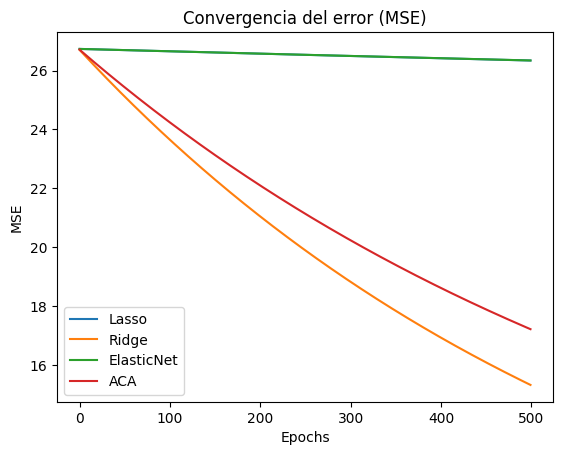

In [665]:
import matplotlib.pyplot as plt

plt.plot(loss_lasso, label="Lasso")
plt.plot(loss_ridge, label="Ridge")
plt.plot(loss_elastic, label="ElasticNet")
plt.plot(loss_aca, label="ACA")
plt.legend()
plt.title("Convergencia del error (MSE)")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()


### Conjunto de datos con 50 características completamente independientes de las cuales solo 10 son predictivas.

In [666]:
n_samples = 1000
n_features = 50
n_predictive = 10

X = np.random.normal(size=(n_samples, n_features))  # features independientes

# pesos verdaderos: solo 10 features predictivas
true_w = np.zeros(n_features)
predictive_idx = np.random.choice(n_features, n_predictive, replace=False)
true_w[predictive_idx] = np.random.uniform(1.0, 3.0, size=n_predictive)

# sesgo y ruido
b_true = 0.5
noise = np.random.normal(scale=0.5, size=n_samples)
y = X @ true_w + b_true + noise

In [667]:
# Separamos nuestros datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [668]:
# Entrenamos los 4 modelos

lambda_r = 0.2
lambda_l = 1
C = np.array([np.max(np.abs(np.delete(row, i))) for i, row in enumerate(np.corrcoef(X_train.T))])
alpha = 0.0001

W_ridge, b_ridge, loss_ridge = train_model(update_weights_with_ridge, X_train, y_train, alpha=alpha, lambda_c=lambda_r)
W_lasso, b_lasso, loss_lasso = train_model(update_weights_with_lasso, X_train, y_train, alpha=alpha, lambda_c=lambda_l)
W_elastic, b_elastic, loss_elastic = train_model(update_weights_with_elasticnet, X_train, y_train, alpha=alpha, lambda_r=lambda_r, lambda_l=lambda_l)
W_aca, b_aca, loss_aca = train_model(update_weights_with_aca, X_train, y_train, alpha=alpha, lambda_r=lambda_r, lambda_l=lambda_l, C=C)

In [669]:
models = {
    "Lasso": (W_lasso, b_lasso),
    "Ridge": (W_ridge, b_ridge),
    "ElasticNet": (W_elastic, b_elastic),
    "ACA": (W_aca, b_aca)
}

for name, (W, b) in models.items():
    mse_tr, mse_te, nonzero = evaluate(W, b, X_train, X_test, y_train, y_test)
    print(f"{name:10s} | MSE_train: {mse_tr:.3f} | MSE_test: {mse_te:.3f} | Features no-cero: {nonzero}")

Lasso      | MSE_train: 31.590 | MSE_test: 32.935 | Features no-cero: 9
Ridge      | MSE_train: 29.830 | MSE_test: 31.274 | Features no-cero: 46
ElasticNet | MSE_train: 31.597 | MSE_test: 32.942 | Features no-cero: 9
ACA        | MSE_train: 31.444 | MSE_test: 32.788 | Features no-cero: 10


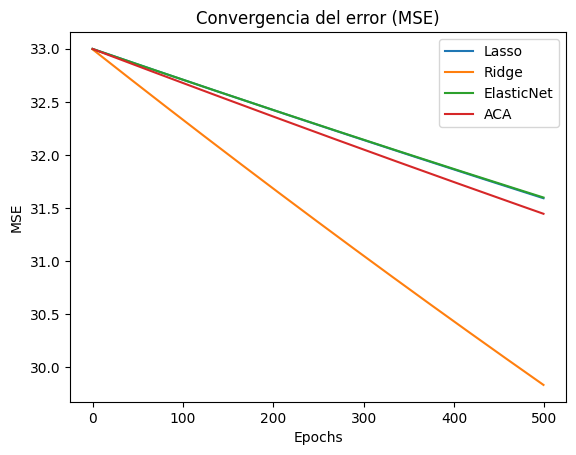

In [670]:
import matplotlib.pyplot as plt

plt.plot(loss_lasso, label="Lasso")
plt.plot(loss_ridge, label="Ridge")
plt.plot(loss_elastic, label="ElasticNet")
plt.plot(loss_aca, label="ACA")
plt.legend()
plt.title("Convergencia del error (MSE)")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

### Conjunto de datos con estructura de correlación gradual
Características ordenadas donde características i correlaciona con características j como
$ρ = exp(−|i − j|/5)$.

In [671]:
from scipy.linalg import toeplitz

n_samples = 1000
n_features = 50
n_predictive = 10
decay = 5  # para la correlación gradual

# Matriz de correlación gradual
corr_vector = np.exp(-np.arange(n_features) / decay)
Sigma = toeplitz(corr_vector)  # Toeplitz: cada fila es un desplazamiento

# Generar features multivariadas normales
X = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Sigma, size=n_samples)

# Pesos verdaderos: solo n_predictive features son predictivas
true_w = np.zeros(n_features)
predictive_idx = np.random.choice(n_features, n_predictive, replace=False)
true_w[predictive_idx] = np.random.uniform(1.0, 3.0, size=n_predictive)

# Sesgo y ruido
b_true = 0.5
noise = np.random.normal(scale=0.5, size=n_samples)

# Generar etiquetas
y = X @ true_w + b_true + noise

In [672]:
# Separamos nuestros datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [680]:
# Entrenamos los 4 modelos

lambda_r = 0.2
lambda_l = 6
C = np.array([np.max(np.abs(np.delete(row, i))) for i, row in enumerate(np.corrcoef(X_train.T))])
alpha = 0.0001

W_ridge, b_ridge, loss_ridge = train_model(update_weights_with_ridge, X_train, y_train, alpha=alpha, lambda_c=lambda_r)
W_lasso, b_lasso, loss_lasso = train_model(update_weights_with_lasso, X_train, y_train, alpha=alpha, lambda_c=lambda_l)
W_elastic, b_elastic, loss_elastic = train_model(update_weights_with_elasticnet, X_train, y_train, alpha=alpha, lambda_r=lambda_r, lambda_l=lambda_l)
W_aca, b_aca, loss_aca = train_model(update_weights_with_aca, X_train, y_train, alpha=alpha, lambda_r=lambda_r, lambda_l=lambda_l, C=C)

In [681]:
models = {
    "Lasso": (W_lasso, b_lasso),
    "Ridge": (W_ridge, b_ridge),
    "ElasticNet": (W_elastic, b_elastic),
    "ACA": (W_aca, b_aca)
}

for name, (W, b) in models.items():
    mse_tr, mse_te, nonzero = evaluate(W, b, X_train, X_test, y_train, y_test)
    print(f"{name:10s} | MSE_train: {mse_tr:.3f} | MSE_test: {mse_te:.3f} | Features no-cero: {nonzero}")

Lasso      | MSE_train: 104.613 | MSE_test: 105.988 | Features no-cero: 2
Ridge      | MSE_train: 48.371 | MSE_test: 48.883 | Features no-cero: 50
ElasticNet | MSE_train: 104.613 | MSE_test: 105.989 | Features no-cero: 2
ACA        | MSE_train: 59.174 | MSE_test: 59.948 | Features no-cero: 50


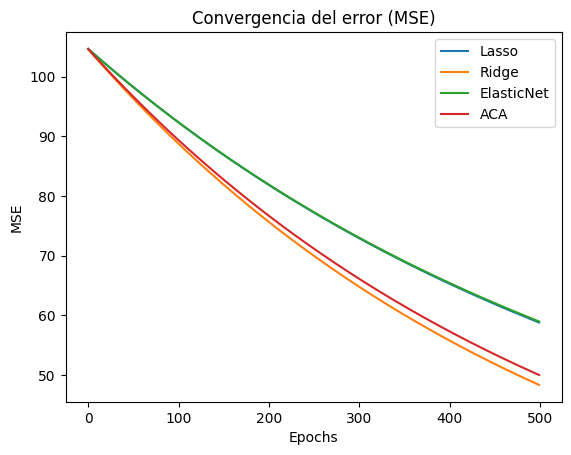

In [675]:
import matplotlib.pyplot as plt

plt.plot(loss_lasso, label="Lasso")
plt.plot(loss_ridge, label="Ridge")
plt.plot(loss_elastic, label="ElasticNet")
plt.plot(loss_aca, label="ACA")
plt.legend()
plt.title("Convergencia del error (MSE)")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()